In [1]:
import os
os.environ['CUPY_ACCELERATORS'] = 'cutensor'
import numpy as np
import cupy as cp
from scipy import misc
from matplotlib import pyplot, cm
from PIL import Image
from tqdm.notebook import tqdm
from IPython.display import display

In [2]:
def semicircle(x):
    """Return the positive y coordinate associated to an x coordinate in a unit circle."""
    return cp.sqrt(1.0 - cp.square(x))

def semicircle_integral(x):
    """Return the indefinite integral at x of the semicircle function."""
    return (cp.sqrt(1.0 - cp.square(x)) * x + cp.arcsin(x))/2

def semicircle_box_area(lower_x, upper_x, lower_y, upper_y):
    """Return the area of the intersection of a box against the unit semicircle."""

    # Compute horizontal intervals defined by the intersection of each vertical coordinate with the circle
    circle_interval = semicircle(y_interval)

    # Clamp the horizontal intervals according to the column regions given by the circle horizontal intervals
    x_interval = np.clip(x_interval, -circle_interval, circle_interval)

    # Compute the indefinite integral at each horizontal interval boundary
    integrals = semicircle_integral(x_interval)

    # Compute the area
    return np.tensordot(integrals - x_interval * y_interval, [[-1.0, 1.0], [1.0, -1.0]])

def circle_box_area(lower_x, upper_x, lower_y, upper_y):
    """Return the area of the intersection of a box against the unit circle."""
    x_interval = cp.stack((lower_x, upper_x), axis=-1)
    y_interval = cp.stack((lower_y, upper_y), axis=-1)[..., np.newaxis, :]

    # Clip x to the unit circle domain
    x_interval = cp.clip(x_interval, -1, 1)

    # Split vertical interval into upper and lower halves
    y_interval_above = cp.clip(y_interval, 0, 1)
    y_interval_below = cp.clip(-np.flip(y_interval, axis=-1), 0, 1)

    # Compute semicircle-box intersection areas
    area_above = semicircle_box_area(x_interval, y_interval)
    area_below = semicircle_box_area(x_interval, y_interval)

    # Return the sum of the upper and lower halves
    return area_above + area_below

In [3]:
def compute_coordinates(res, pitch):
    """Return an array of shape (res) containing the coordinates of a sampling lattice with given pitch."""
    indices = np.arange(res)
    return (indices - res/2 + 0.5) * pitch

def compute_indices(x, res, pitch):
    """Return indices for given coordinates with respect to given resolution and pitch."""
    return np.floor(x / pitch + res/2).astype(np.int32)

def ab_to_r(x_a, x_b, z_r, z_a, z_b, z_f):
    """Return the coordinates on the retina corresponding to the given coordinates on planes A and B."""
    return (x_a * (1.0 - z_b/z_f) - x_b * (1.0 - z_a/z_f)) * (z_r / (z_a - z_b))

def take_2d(values, idx_x, idx_y):
    """Return values at given indices. Out of bounds are filled with 0."""
    clipped_idx_x = np.clip(idx_x, -1, values.shape[0]) + 1
    clipped_idx_y = np.clip(idx_y, -1, values.shape[1]) + 1
    return np.pad(values, 1, mode='constant')[clipped_idx_x, clipped_idx_y]

def compute_intervals_at_pupil(x_r, x_a, x_b, w_a, w_b, z_r, z_a, z_b, z_f, pupil_diameter):
    """Return the intervals of display elements projected at the pupil."""
    # Project display samples to the pupil plane
    x_a_at_p = (x_a - x_r * (z_a/z_r)) * np.reciprocal(1.0 - z_a/z_f)
    x_b_at_p = (x_b - x_r * (z_b/z_r)) * np.reciprocal(1.0 - z_b/z_f)
    # Project display element sizes to the pupil plane
    w_a_at_p = np.abs(w_a * np.reciprocal(1.0 - z_a/z_f))
    w_b_at_p = np.abs(w_b * np.reciprocal(1.0 - z_b/z_f))
    # Compute lower and upper bounds of projected display elements
    lower_bounds = np.clip(x_a_at_p - w_a_at_p/2, x_b_at_p - w_b_at_p/2, x_b_at_p + w_b_at_p/2)
    upper_bounds = np.clip(x_a_at_p + w_a_at_p/2, x_b_at_p - w_b_at_p/2, x_b_at_p + w_b_at_p/2)
    # Stack array as [..., 2] where the last dimension is lower|upper bounds
    pupil_intervals = np.stack((lower_bounds, upper_bounds), axis=-1)
    # Scale and clip the intervals to the unit pupil
    pupil_intervals = np.clip(pupil_intervals * 2/pupil_diameter, -1, 1)
    return pupil_intervals

def decimate_lf(signal_ab, factor):
    """Return the light field decimated by the given factor."""
    return signal_ab[factor//2::factor, factor//2::factor, factor//2::factor, factor//2::factor]

def tile_lf(signal_ab):
    """Return a 2-dim tiling of 2-dim images from given 4-dim light field."""
    return signal_ab.reshape(np.prod(signal_ab.shape[0:2]), -1)

def display_image(values, normalize=True, color_map=None):
    """Display an array of values as an image using a color map."""
    values = values * np.nan_to_num(1.0 / np.amax(values)) if normalize else values
    color_values = cm.get_cmap(color_map)(values, bytes=True)
    display(Image.fromarray(color_values).transpose(Image.ROTATE_90))

In [4]:
z_r = -17.0
z_a = 10.0
z_b = 30.0

pupil_diameter = 5.0

size_r = 5.5
size_a = size_r * z_a / abs(z_r) + pupil_diameter
size_b = size_r * z_b / abs(z_r) + pupil_diameter

res_r = 384
res_a = 128
res_b = 128

pitch_r = size_r / res_r
pitch_a = size_a / res_a
pitch_b = size_b / res_b

w_a = pitch_a
w_b = pitch_b

In [5]:
x_r = compute_coordinates(res_r, pitch_r)
xi_r =  np.fft.fftfreq(res_r, pitch_r)

x_a = compute_coordinates(res_a, pitch_a)
xi_a =  np.fft.fftfreq(res_a, pitch_a)

x_b = compute_coordinates(res_b, pitch_b)
xi_b =  np.fft.fftfreq(res_b, pitch_b)

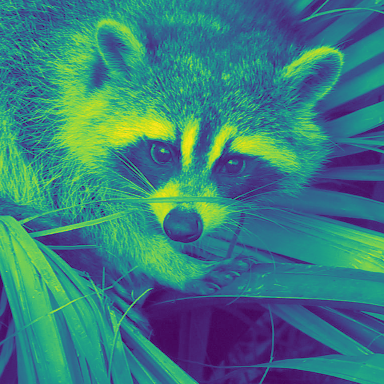

(384, 384) uint8 | total size: 0.0001373291015625 GiB


In [6]:
scene_image = misc.face(True).T[-769:-1:2, ::-2]
display_image(scene_image)
print(scene_image.shape, scene_image.dtype, '| total size:', scene_image.nbytes/2**30, 'GiB')

In [7]:
%%time
print('Sampling the light field signal...')

z_f = 1000.0

x_r_over_ab = ab_to_r(x_a[:, np.newaxis], x_b[np.newaxis, :], z_r, z_a, z_b, z_f)
idx_r_over_ab = compute_indices(x_r_over_ab, res_r, pitch_r)
signal_ab = take_2d(scene_image, idx_r_over_ab[:, np.newaxis, :, np.newaxis], idx_r_over_ab[np.newaxis, :, np.newaxis, :])

print(signal_ab.shape, signal_ab.dtype, '| total size:', signal_ab.nbytes/2**30, 'GiB')

Sampling the light field signal...
(128, 128, 128, 128) uint8 | total size: 0.25 GiB
Wall time: 959 ms


Computing retinal image on GPU...


  0%|          | 0/147456 [00:00<?, ?it/s]

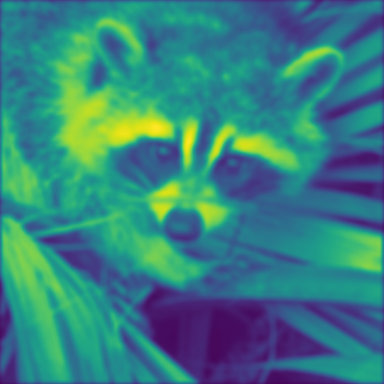

Wall time: 1h 53min 22s


In [8]:
%%time
print('Computing retinal image on GPU...')

pupil_intervals = compute_intervals_at_pupil(x_r[:, np.newaxis, np.newaxis], x_a[np.newaxis, :, np.newaxis], x_b[np.newaxis, np.newaxis, :], w_a, w_b, z_r, z_a, z_b, z_f, pupil_diameter).astype(np.float32)

signal_GPU = cp.asarray(signal_ab)
intervals_GPU = cp.asarray(pupil_intervals)

retinal_image = np.zeros((res_r, res_r))

for idx_r in tqdm(np.ndindex((res_r, res_r)), total=res_r**2, leave=False):
    x_intervals = intervals_GPU[idx_r[0]][:, np.newaxis, :, np.newaxis, :]
    y_intervals = intervals_GPU[idx_r[1]][np.newaxis, :, np.newaxis, :, :]
    #img_tsr = circle_box_area(x_intervals, y_intervals)
    img_tsr = cp.subtract(x_intervals[..., 1], x_intervals[..., 0]) * cp.subtract(y_intervals[..., 1], y_intervals[..., 0])
    retinal_image[idx_r] = cp.sum(signal_GPU * img_tsr)

display_image(retinal_image)

Computing retinal image on GPU with nonabutting lixels...


  0%|          | 0/147456 [00:00<?, ?it/s]

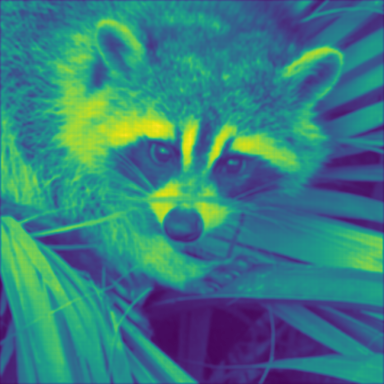

Wall time: 4h 59min 35s


In [9]:
%%time
print('Computing retinal image on GPU with nonabutting lixels...')

pupil_intervals = compute_intervals_at_pupil(x_r[:, np.newaxis, np.newaxis], x_a[np.newaxis, :, np.newaxis], x_b[np.newaxis, np.newaxis, :], w_a/2, w_b/2, z_r, z_a, z_b, z_f, pupil_diameter).astype(np.float32)

signal_GPU = cp.asarray(signal_ab)
intervals_GPU = cp.asarray(pupil_intervals)

retinal_image = np.zeros((res_r, res_r))

for idx_r in tqdm(np.ndindex((res_r, res_r)), total=res_r**2, leave=False):
    x_intervals = intervals_GPU[idx_r[0]][:, np.newaxis, :, np.newaxis, :]
    y_intervals = intervals_GPU[idx_r[1]][np.newaxis, :, np.newaxis, :, :]
    #img_tsr = circle_box_area(x_intervals, y_intervals)
    img_tsr = cp.subtract(x_intervals[..., 1], x_intervals[..., 0]) * cp.subtract(y_intervals[..., 1], y_intervals[..., 0])
    retinal_image[idx_r] = cp.sum(signal_GPU * img_tsr)

display_image(retinal_image)

Computing retinal image on GPU with nonabutting lixels...


  0%|          | 0/147456 [00:00<?, ?it/s]

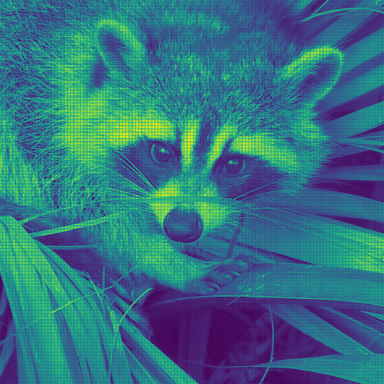

Wall time: 4h 24min 1s


In [10]:
%%time
print('Computing retinal image on GPU with nonabutting lixels...')

pupil_intervals = compute_intervals_at_pupil(x_r[:, np.newaxis, np.newaxis], x_a[np.newaxis, :, np.newaxis], x_b[np.newaxis, np.newaxis, :], w_a/8, w_b/8, z_r, z_a, z_b, z_f, pupil_diameter).astype(np.float32)

signal_GPU = cp.asarray(signal_ab)
intervals_GPU = cp.asarray(pupil_intervals)

retinal_image = np.zeros((res_r, res_r))

for idx_r in tqdm(np.ndindex((res_r, res_r)), total=res_r**2, leave=False):
    x_intervals = intervals_GPU[idx_r[0]][:, np.newaxis, :, np.newaxis, :]
    y_intervals = intervals_GPU[idx_r[1]][np.newaxis, :, np.newaxis, :, :]
    #img_tsr = circle_box_area(x_intervals, y_intervals)
    img_tsr = cp.subtract(x_intervals[..., 1], x_intervals[..., 0]) * cp.subtract(y_intervals[..., 1], y_intervals[..., 0])
    retinal_image[idx_r] = cp.sum(signal_GPU * img_tsr)

display_image(retinal_image)